# Autoencoder Block Compression



*   Manuel David Montesinos Navarrete
*   Miguel Torres Álamo
*   Iván Castells Galindo
*   Juan Ignacion Castro Carmona





In the image compression methodology presented in this notebook, we employ a segmentation approach combined with an autoencoder. The image is segmented into discrete blocks with dimensions of (i.e) 16 x 16. Subsequently, each of these blocks is transformed into its latent space representation via a trained encoder and further compressed with range-encoding. In the end, a binary compressed file with extension .AEBC is saved as a result of combining the compressed blocks with essential metadata (such as original image shape).

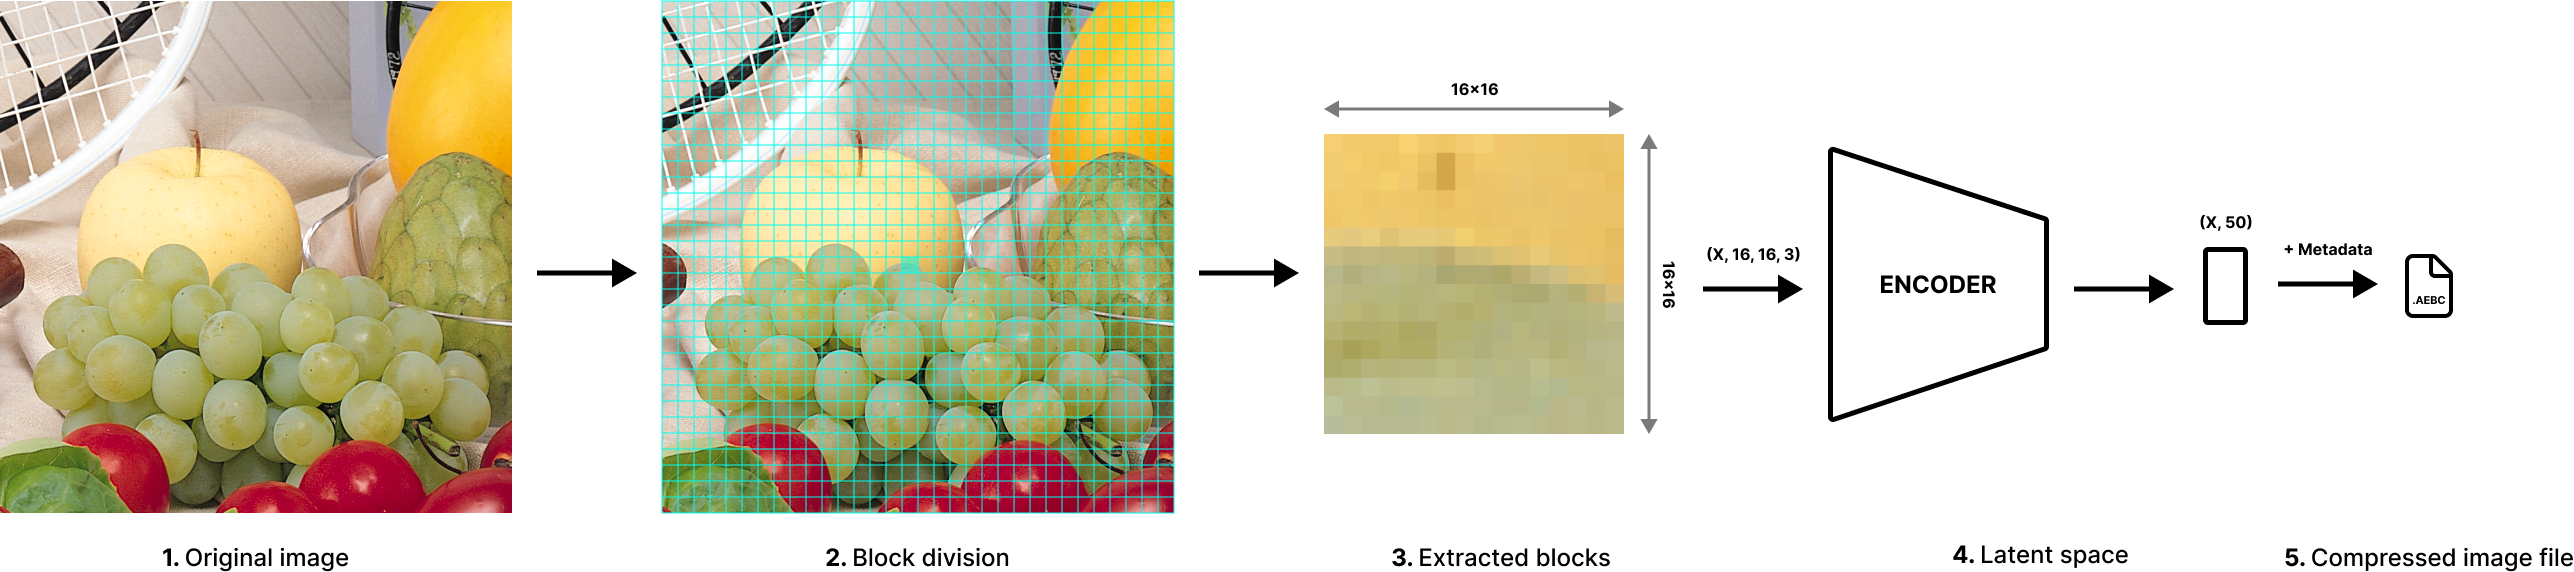

The decompression methodology begins with the previously saved .AEBD file, from which the blocks' compressed representations are recovered and fed into decoder. This decoder then reconstructs each block to form the decompressed image after applying a gaussian blur along the edges.

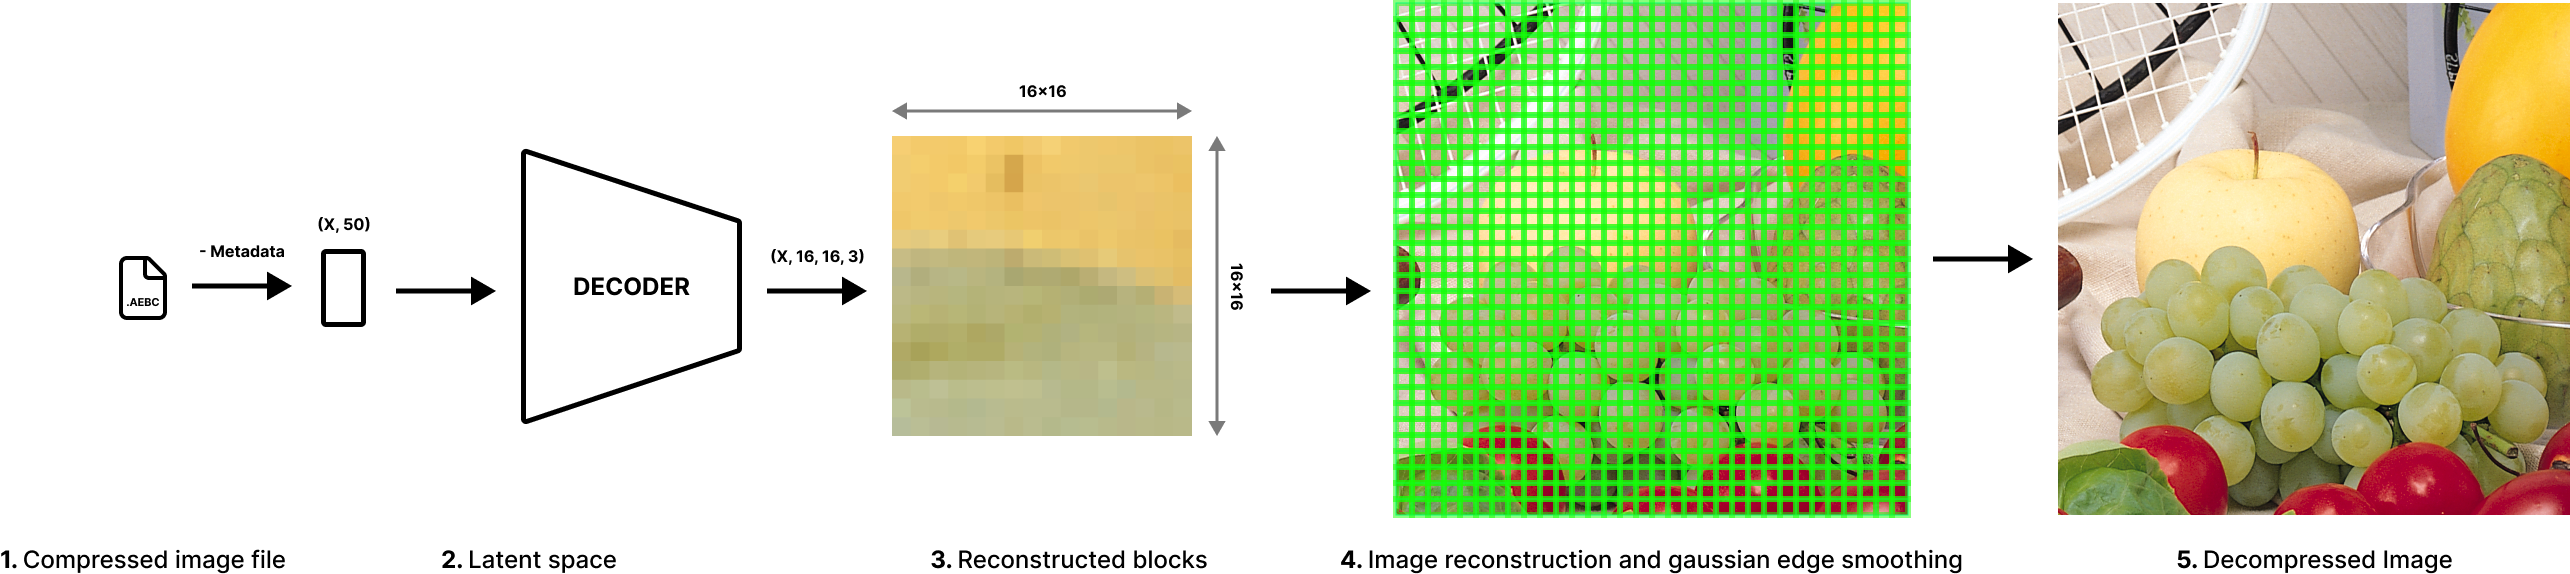

## Setup

Import library dependencies.

In [1]:
%%bash
pip install tensorflow_compression
pip uninstall tensorflow -y
pip install --upgrade tensorflow=='2.14.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: t

In [2]:

from datetime import datetime
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import numpy as np
import nbformat
import os
import cv2
import random
import struct
from os import stat
import time

DISPLAY_TIMES = False

def _time(f):
    def wrapper(*args):
        if not DISPLAY_TIMES:
            return f(*args)
        start = time.time()
        r = f(*args)
        end = time.time()
        print("%s timed %fs" % (f.__qualname__, end-start))
        return r
    return wrapper

Import desired dataset for training and validation

In [24]:
training_dataset, validation_dataset = tfds.load(
    "dmlab",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=False,
    with_info=False,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/65550 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dmlab/2.0.1.incompleteBKZT7C/dmlab-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/22628 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dmlab/2.0.1.incompleteBKZT7C/dmlab-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/22735 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dmlab/2.0.1.incompleteBKZT7C/dmlab-test.tfrecord*...:   0%|          | 0/2…

Dataset dmlab downloaded and prepared to /root/tensorflow_datasets/dmlab/2.0.1. Subsequent calls will reuse this data.


In [25]:
# Grabs the image from the used dataset. It is a helper function that allows switching from
# one dataset to another easily
def get_img_from_dataset(dataset_item):
    return dataset_item["image"]

Data type: <dtype: 'uint8'>
Shape: (360, 480, 3)


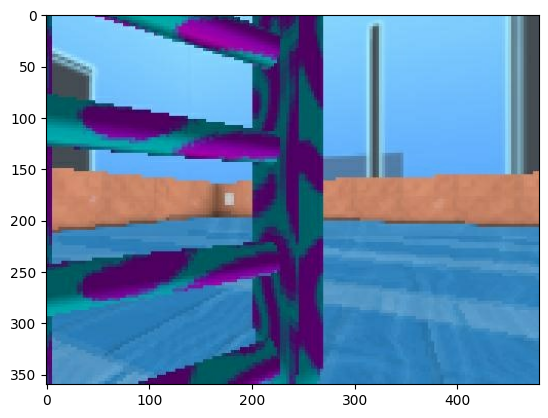

In [26]:
sample_image, = validation_dataset.take(1)
#print(sample_image)
image = sample_image["image"]
plt.imshow(tf.squeeze(image))
print(f"Data type: {image.dtype}")
print(f"Shape: {image.shape}")

## Define the model architecture and trainer.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image block into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image block space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [3]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

In [4]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          800, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [5]:
BLOCK_SIZE = 16

The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the image blocks, and
- **distortion**, the root mean absolute difference between the pixels of the original blocks and their reconstructions.


In [6]:
@tf.keras.saving.register_keras_serializable()
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for block-based image compression."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, BLOCK_SIZE, BLOCK_SIZE, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Total number of bits divided by number of pixels (bpp).
    num_pixels = tf.cast(tf.reduce_prod(tf.shape(x)[:-1]), rate.dtype)
    rate = tf.reduce_sum(rate) / num_pixels

    # Root mean square error across pixels.
    distortion = tf.sqrt(tf.reduce_mean(tf.square(x - x_tilde)))

    return dict(rate=rate, distortion=distortion)

Display model architecture with desired latent_dimensions:

In [27]:
sample_latent_dims = 50
sample_model = CompressionTrainer(sample_latent_dims)
sample_model.build((BLOCK_SIZE, BLOCK_SIZE, 3))
sample_model.summary(expand_nested=True)

Model: "compression_trainer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 analysis_transform (Sequen  (1, 50)                   452120    
 tial)                                                           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv_1 (Conv2D)            (1, 8, 8, 20)             1520     |
|                                                               |
| conv_2 (Conv2D)            (1, 4, 4, 50)             25050    |
|                                                               |
| flatten_1 (Flatten)        (1, 800)                  0        |
|                                                               |
| fc_1 (Dense)               (1, 500)                  400500   |
|                                                               |
| fc_2 (Dense)               (1, 50)                   25050    |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

## Define functions to divide/reconstruct images from blocks

In [7]:
@_time
def divide_into_blocks(image, block_size=BLOCK_SIZE):
  # Calculate the number of blocks along each axis
  num_blocks_x = (image.shape[0] + block_size - 1) // block_size
  num_blocks_y = (image.shape[1] + block_size - 1) // block_size

  padded_image = np.pad(image, ((0, num_blocks_x * block_size - image.shape[0]), (0, num_blocks_y * block_size - image.shape[1]), (0, 0)), mode='edge')

  blocks = padded_image.reshape(num_blocks_x, block_size, num_blocks_y, block_size, 3).swapaxes(1, 2).reshape(num_blocks_x * num_blocks_y, block_size, block_size, 3)

  return blocks

In [8]:
def get_random_block(img, block_size=BLOCK_SIZE):
    img = tf.squeeze(img)
    height, width = img.shape[:2]

    num_blocks_row = (height + block_size - 1) // block_size
    num_blocks_col = (width + block_size - 1) // block_size

    i = random.randint(0, num_blocks_row)
    j = random.randint(0, num_blocks_col)

    start_y = i * block_size
    end_y = min((i + 1) * block_size, height)
    start_x = j * block_size
    end_x = min((j + 1) * block_size, width)

    block = img[start_y:end_y, start_x:end_x]
    shape_original = block.shape

    if block.shape[0] < block_size and block.shape[1] < block_size:
        block = img[end_y-block_size:end_y, end_x-block_size:end_x]

    elif block.shape[0] < block_size:
        block = img[end_y-block_size:end_y, start_x:end_x]

    elif block.shape[1] < block_size:
        block = img[start_y:end_y, end_x-block_size:end_x]

    return tf.convert_to_tensor(block, dtype=img.dtype)

In [9]:
@_time
def reconstruct_image(blocks, original_shape, block_size=BLOCK_SIZE):
    adjusted_shape = (
        (original_shape[0] + block_size - 1) // block_size * block_size,
        (original_shape[1] + block_size - 1) // block_size * block_size,
        original_shape[2]
    )

    num_blocks_x = adjusted_shape[0] // block_size
    num_blocks_y = adjusted_shape[1] // block_size

    reconstructed_image = blocks.reshape(num_blocks_x, num_blocks_y, block_size, block_size, 3).swapaxes(1, 2).reshape(adjusted_shape)

    return reconstructed_image[:original_shape[0], :original_shape[1], :]

In [10]:
@_time
def smooth_edges_gaussian(image, block_size, mask_size, offset):
    height, width = image.shape[:2]
    mask = np.zeros_like(image)

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[max(0, i - offset): min(height, i + block_size + offset),
                          max(0, j - offset): min(width, j + block_size + offset)]

            smoothed = cv2.GaussianBlur(block, (mask_size, mask_size), 0)

            mask[i:i + block_size, j:j + block_size] = smoothed[
                offset:offset + block_size, offset:offset + block_size]

    return mask

## Define functions to train, save and load the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [11]:
@tf.keras.saving.register_keras_serializable()
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=50):
  trainer = CompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


In [12]:
# Callback after each epoch that tests the model against a sample image
class RDCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(RDCallback, self).__init__()
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        # Obtain a sample image from the dataset
        x_batch = validation_dataset.map(get_img_from_dataset).batch(1).skip(3).take(1)
        x = next(iter(x_batch))
        x_image = x.numpy().squeeze().astype(np.uint8)

        # Divide image into blocks and obtain its compressed representation
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=True)
        blocks = tf.convert_to_tensor(divide_into_blocks(x_image))
        y = self.model.analysis_transform(blocks)
        y_tilde, rate = entropy_model(y, training=False)
        y_tilde_codestream = entropy_model.compress(y)

        # Decompress each block into its original space
        x_tilde = self.model.synthesis_transform(y_tilde)

        # Compute rate in bpp as average of all blocks
        bit_rate_in_bits_per_pixel = np.mean([len(bytes.numpy()) for bytes in y_tilde_codestream]) / (BLOCK_SIZE*BLOCK_SIZE)

        # Reconstruct image from recovered blocks
        reconstructed_image = reconstruct_image(x_tilde.numpy(), x_image.shape).squeeze().astype(np.uint8)

        # Compute reconstruction distortion in both RMSE and MSSSIM
        distortion_rmse = tf.sqrt(tf.reduce_mean(tf.square(x_image.astype(np.double) - reconstructed_image.astype(np.double))))
        distortion_msssim = tf.squeeze(tf.image.ssim_multiscale(x_image.astype(np.double), reconstructed_image.astype(np.double), 255))

        print(f"\nR={bit_rate_in_bits_per_pixel} D(RMSE)={distortion_rmse} D(MSSSIM)={distortion_msssim} \n")

        # Display both original and reconstructed image
        plt.subplot(1, 3, 1)
        plt.imshow(x_image)
        plt.subplot(1, 3, 2)
        plt.imshow(reconstructed_image)

        # Show validation loss curve
        if logs is not None and 'val_loss' in logs:
            self.losses.append(logs['val_loss'])
            plt.subplot(1, 3, 3)
            plt.plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            plt.title('Validation Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (J)')

        plt.tight_layout()
        plt.show()

In [13]:
def save_model(model, lmbda):
    print("Saving model... Please wait")

    model_name = datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + f"-lambda{lmbda}-{BLOCK_SIZE}x{BLOCK_SIZE}"

    model.save("models/" + model_name + ".keras")

    # Save encoder and decoder code from current notebook
    notebook_name = "AutoencoderBlockCompression.ipynb"
    with open(notebook_name, "r", encoding="utf-8") as notebook_file:
        notebook_content = nbformat.read(notebook_file, as_version=4)

    encoder_notebook_block_index = 15
    decoder_notebook_block_index = 16

    encoder_notebook_block_code = notebook_content['cells'][encoder_notebook_block_index]['source']
    decoder_notebook_block_code = notebook_content['cells'][decoder_notebook_block_index]['source']

    # Write summary file with model architecture and analysis/transform code
    with open("models/" + model_name + ".txt", "w") as summary_file:
        model.summary(expand_nested=True, print_fn=lambda x: summary_file.write(x + "\n"))
        summary_file.write("\n\n")
        summary_file.write(encoder_notebook_block_code)
        summary_file.write("\n\n\n")
        summary_file.write(decoder_notebook_block_code)
        summary_file.write("\n")

    # Test model against sample dataset image and save training results
    results_filename = "results.csv"
    hist = model.history.history

    x_batch = validation_dataset.map(get_img_from_dataset).batch(1).skip(3).take(1)
    x = next(iter(x_batch))
    x_image = x.numpy().squeeze().astype(np.uint8)

    entropy_model = tfc.ContinuousBatchedEntropyModel(model.prior, coding_rank=1, compression=True)
    blocks = tf.convert_to_tensor(divide_into_blocks(x_image))
    y = model.analysis_transform(blocks)
    y_tilde, rate = entropy_model(y, training=False)
    y_tilde_codestream = entropy_model.compress(y)

    x_tilde = model.synthesis_transform(y_tilde)

    bit_rate_in_bits_per_pixel = np.mean([len(bytes.numpy()) for bytes in y_tilde_codestream]) / (BLOCK_SIZE*BLOCK_SIZE)

    reconstructed_image = reconstruct_image(x_tilde.numpy(), x_image.shape).squeeze().astype(np.uint8)

    distortion = tf.sqrt(tf.reduce_mean(tf.square(x_image.astype(np.double) - reconstructed_image.astype(np.double)))) # RMSE
    rd = bit_rate_in_bits_per_pixel + distortion

    data = [model_name, lmbda, bit_rate_in_bits_per_pixel, distortion.numpy(), rd.numpy(),
            hist["loss"][-1], hist["distortion_loss"][-1],
            hist["rate_loss"][-1], hist["val_loss"][-1],
            hist["val_distortion_loss"][-1],hist["val_rate_loss"][-1]]

    with open(results_filename, "a") as results_file:
        writer = csv.writer(results_file)
        writer.writerow(data)

    # Test model against test images and save its results
    results_filename = "results-test.csv"

    filenames = ["fruits.png", "lena.png", "mandril.png", "pajarillo.png", "peppers.png"]
    entropy_model = tfc.ContinuousBatchedEntropyModel(model.prior, coding_rank=1, compression=True)

    results_dict = { "model": model_name, "lambda": lmbda, "block_size": BLOCK_SIZE }

    for filename in filenames:
        filename, ext = filename.split(".")

        image_file = tf.keras.utils.load_img(f"test_images/{filename}.{ext}")
        image_array = tf.keras.utils.img_to_array(image_file)
        test_image = tf.convert_to_tensor(image_array)
        test_image = tf.squeeze(test_image)
        test_image = test_image.numpy()

        blocks = tf.convert_to_tensor(divide_into_blocks(test_image))
        y = model.analysis_transform(blocks)
        y_tilde, rate = entropy_model(y, training=False)
        y_tilde_codestream = entropy_model.compress(y)

        x_tilde = model.synthesis_transform(y_tilde)
        reconstructed_image = reconstruct_image(x_tilde.numpy(), test_image.shape).squeeze().astype(np.uint8)

        distortion_rmse = tf.sqrt(tf.reduce_mean(tf.square(test_image.astype(np.double) - reconstructed_image.astype(np.double))))
        distortion_msssim = tf.squeeze(tf.image.ssim_multiscale(test_image.astype(np.double), reconstructed_image.astype(np.double), 255))
        bit_rate_in_bits_per_pixel = np.mean([len(bytes.numpy()) for bytes in y_tilde_codestream]) / (BLOCK_SIZE*BLOCK_SIZE)
        theoretical_size = np.sum([len(bytes.numpy()) for bytes in y_tilde_codestream]) / 8

        results_dict[f"{filename}-R"] = bit_rate_in_bits_per_pixel
        results_dict[f"{filename}-D(RMSE)"] = distortion_rmse.numpy()
        results_dict[f"{filename}-D(MSSSIM)"] = distortion_msssim.numpy()
        results_dict[f"{filename}-size"] = theoretical_size

    with open(results_filename, "a") as results_file:
        fieldnames = ['model', 'lambda', 'block_size',
                      'fruits-R', 'fruits-D(RMSE)', 'fruits-D(MSSSIM)', 'fruits-size',
                      'lena-R', 'lena-D(RMSE)', 'lena-D(MSSSIM)', 'lena-size',
                      'mandril-R', 'mandril-D(RMSE)', 'mandril-D(MSSSIM)', 'mandril-size',
                      'pajarillo-R', 'pajarillo-D(RMSE)', 'pajarillo-D(MSSSIM)', 'pajarillo-size',
                      'peppers-R', 'peppers-D(RMSE)', 'peppers-D(MSSSIM)', 'peppers-size']
        writer = csv.DictWriter(results_file, fieldnames)
        writer.writerow(results_dict)

    print("Model saved!")

def load_model(path):
    return tf.keras.models.load_model(path)

Next, train the model. The human annotations are not necessary here, since we just want to compress the image blocks, so we drop them using a `map` and instead add "dummy" targets for rate and distortion. Block dataset is constructed by obtaining a random block from every image.

In [14]:
def add_rd_targets(image):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_model(lmbda, latent_dims, save = False, early_stop=False):
  callback_list = [RDCallback(),
                   tf.keras.callbacks.BackupAndRestore("tmp")]
  if (early_stop):
      callback_list.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1))

  trainer = make_compression_trainer(lmbda, latent_dims)

  # Build block datasets
  training_block_dataset = training_dataset.map(get_img_from_dataset).map(get_random_block).map(add_rd_targets).batch(128).prefetch(8)
  validation_block_dataset = validation_dataset.map(get_img_from_dataset).map(get_random_block).map(add_rd_targets).batch(128).prefetch(8)

  (sample_iteration, _) = next(iter(training_block_dataset))
  print("Dataset iteration shape: ")
  print(sample_iteration.shape)

  trainer.fit(
      training_block_dataset,
      epochs=15,
      validation_data=validation_block_dataset,
      validation_freq=1,
      verbose=1,
      callbacks=callback_list
  )

  if save:
    save_model(trainer, lmbda)

  return trainer

## Define compression and decompression model classes.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [15]:
class Compressor(tf.keras.Model):
  """Compresses images to bytes codestreams."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  @_time
  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.

    # Divides image into blocks and converts them to tensor
    blocks = divide_into_blocks(x)
    blocks_tensor = tf.convert_to_tensor(blocks)

    # Compresses blocks tensor
    y = self.analysis_transform(blocks_tensor)
    _, entropies = self.entropy_model(y, training=False)
    y_tilde = self.entropy_model.compress(y)

    # Obtains a bytes codestream packed with original image shape (as unsigned short) and compressed blocks
    compressed_codestream = np.append([struct.pack("H", x.shape[0]), struct.pack("H", x.shape[1])], y_tilde)

    # Returns codestream and total compressed entropy
    return compressed_codestream, np.sum(entropies)

In [16]:
class Decompressor(tf.keras.Model):
  """Decompresses images from bytes codestreams."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  @_time
  def call(self, bytes_codestream, smooth_output = True):
    bytes_codestream = bytes_codestream.numpy()

    # Unpacks original image shape from codestream
    width = struct.unpack("H", bytes_codestream[0])[0]
    height = struct.unpack("H", bytes_codestream[1])[0]
    shape = (width, height, 3)

    # Gets compressed blocks tensor
    compressed_tensor = tf.convert_to_tensor(bytes_codestream[2:])

    # Decompresses tensor
    y_hat = self.entropy_model.decompress(compressed_tensor, ())
    x_hat = self.synthesis_transform(y_hat)

    # Scale and cast back to 8-bit integer.
    decompressed_blocks = tf.squeeze(tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8))

    # Reconstruct image from decompressed blocks
    image = reconstruct_image(decompressed_blocks.numpy(), shape)

    # Smooths the image to improve quality
    if smooth_output:
        image = smooth_edges_gaussian(image, BLOCK_SIZE, 3, 2)

    return image

When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [17]:
def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

## Save/Load images to disk functions

In [18]:
FILE_EXTENSION = "aebc"

@_time
def save_compressed_image(filename, bytes_codestream, display_msg = False):
    file_path = f"compressed_images/{filename}.{FILE_EXTENSION}"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with open(file_path, "wb") as file:
        # Writes the bytes that correspond to image shape
        file.write(bytes_codestream[0])
        file.write(bytes_codestream[1])

        # Writes each block by packing first its length as an unsigned char
        for block in bytes_codestream[2:]:
            file.write(struct.pack("B", len(block)))
            file.write(block)

    if display_msg:
        print(f"Saved compressed image {filename}!")

@_time
def load_compressed_image(filename):
    file_path = f"compressed_images/{filename}.{FILE_EXTENSION}"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    bytes_codestream = []

    with open(file_path, "rb") as file:
        # Reads image shape
        bytes_codestream.append(file.read(2))
        bytes_codestream.append(file.read(2))

        # Reads block length and appends recovered block to codestream
        while True:
            length_data = file.read(1)
            if not length_data:
                break
            length = struct.unpack("B", length_data)[0]
            bytes_codestream.append(file.read(length))

    return np.array(bytes_codestream)

def get_compressed_file_bytes_size(filename):
    file_path = f"compressed_images/{filename}.{FILE_EXTENSION}"
    return get_file_bytes_size(file_path)

def get_file_bytes_size(filepath):
    file_stats = os.stat(filepath)
    return file_stats.st_size

## Define display results functions.

In [19]:
def analyze_image(compressor, decompressor, filename, image, original_size):
    compression_start = time.time()
    compressed_codestream, entropy = compressor(image)
    compression_end = time.time()

    save_compressed_image(filename, compressed_codestream)

    compressed_file = load_compressed_image(filename)

    decompression_start = time.time()
    reconstructed_image = decompressor(compressed_file, False)
    decompression_end = time.time()

    smoothing_start = time.time()
    reconstructed_image = smooth_edges_gaussian(reconstructed_image, BLOCK_SIZE, 3, 2)
    smoothing_end = time.time()

    compressed_size = get_compressed_file_bytes_size(filename)

    num_pixels = tf.reduce_prod(tf.shape(image)[:-1])

    rate = (compressed_size*8)/num_pixels
    distortion = tf.sqrt(tf.reduce_mean(tf.square(image.numpy().astype(np.double) - reconstructed_image.astype(np.double))))
    distortion_msssim = tf.squeeze(tf.image.ssim_multiscale(image.numpy().astype(np.double), reconstructed_image.astype(np.double), 255))

    print(f"\nCompression time: {compression_end-compression_start} s | {(compression_end-compression_start)*1000} ms ")
    print(f"Decompression time: {decompression_end-decompression_start} s | {(decompression_end-decompression_start)*1000} ms ")
    print(f"Smoothing time: {smoothing_end-smoothing_start} s | {(smoothing_end-smoothing_start)*1000} ms ")
    print(f"\nOriginal image size: {original_size} bytes | {original_size*8} bits\n")
    print(f"Required size to represent it (entropy): {(entropy/8):0.2f} bytes | {entropy:0.2f} bits")
    print(f"Theoretical Compression factor: x{(original_size*8)/entropy}")
    print(f"\nCompressed file size: {compressed_size} bytes | {compressed_size*8} bits")
    print(f"Real Compression factor: x{original_size/(compressed_size)}")
    print(f"R: {rate} bpp")
    print(f"D: {distortion} (RMSE)")
    print(f"D: {distortion_msssim} (Multiscale SSIM)")

    #JPEG comparison
    jpeg_encoded = tf.image.encode_jpeg(image.numpy().squeeze().astype(np.uint8))

    jpeg_filepath = f"compressed_images/{filename}.jpeg"
    with open(jpeg_filepath, "wb") as file:
        file.write(jpeg_encoded.numpy())

    jpeg_decoded = tf.image.decode_jpeg(jpeg_encoded)

    compressed_size_jpeg = get_file_bytes_size(jpeg_filepath)
    rate_jpeg = (compressed_size_jpeg*8)/num_pixels
    distortion_jpeg = tf.sqrt(tf.reduce_mean(tf.square(image.numpy().astype(np.double) - jpeg_decoded.numpy().astype(np.double))))
    distortion_msssim_jpeg = tf.squeeze(tf.image.ssim_multiscale(image.numpy().astype(np.double), jpeg_decoded.numpy().astype(np.double), 255))

    print(f"\nCompressed jpeg file size: {compressed_size_jpeg} bytes | {compressed_size_jpeg*8} bits")
    print(f"jpeg Compression factor: x{original_size/(compressed_size_jpeg)}")
    print(f"aebc/jpeg Compression factor: x{compressed_size_jpeg/compressed_size}")
    print(f"R: {rate_jpeg} bpp")
    print(f"D: {distortion_jpeg} (RMSE)")
    print(f"D: {distortion_msssim_jpeg} (Multiscale SSIM)")

    ax1 = plt.subplot(1, 3, 1)
    ax1.set_title("Original Image")
    ax1.set_axis_off()
    plt.imshow(image.numpy().squeeze().astype(np.uint8))

    ax2 = plt.subplot(1, 3, 2)
    ax2.set_title("AEBC Image")
    ax2.set_axis_off()
    plt.imshow(reconstructed_image)

    ax3 = plt.subplot(1, 3, 3)
    ax3.set_title("JPEG Image")
    ax3.set_axis_off()
    plt.imshow(jpeg_decoded)

    plt.show()

    print("\n")

def get_image_size_bytes(image_tensor):
    size_in_bytes = tf.reduce_prod(image_tensor.shape) * tf.as_dtype(image_tensor.dtype).size # Calculate original size in bytes
    return tf.cast(size_in_bytes, dtype=tf.float32)

def test_dataset_images(model, num_images = 8):
  compressor, decompressor = make_codec(model)

  originals, = validation_dataset.map(get_img_from_dataset).batch(num_images).skip(3).take(1) # Grab images from the validation dataset
  originals = tf.split(originals, num_or_size_splits=num_images, axis=0)

  for index, image in enumerate(originals):
      filename = str(index)
      print("Image " + filename)

      image = tf.squeeze(image)

      original_size = get_image_size_bytes(image)

      analyze_image(compressor, decompressor, filename, image, original_size)

def test_exam_images(model):
  compressor, decompressor = make_codec(model)

  filenames = ["fruits.png", "lena.png", "mandril.png", "pajarillo.png", "peppers.png"]

  for filename in filenames:
      filename, ext = filename.split(".")
      print("Image " + filename)

      image_file = tf.keras.utils.load_img(f"test_images/{filename}.{ext}")
      image_array = tf.keras.utils.img_to_array(image_file)
      image = tf.convert_to_tensor(image_array)
      image = tf.squeeze(image)

      original_size = get_file_bytes_size(f"test_images/{filename}.{ext}")

      analyze_image(compressor, decompressor, filename, image, original_size)

## Train/Load model and visualize results.

In [21]:
TRAIN = False

if TRAIN:
    lmbda = 5000000
    latent_dims = 30
    save = True
    early_stop = False
    model = train_model(lmbda=lmbda, latent_dims=latent_dims, save=save, early_stop=early_stop)
else:
    model_name = "2024_01_24-16_19_52-lambda2000-16x16"
    model_path = f"models/{model_name}.keras"
    model = load_model(model_path)
    print("Loaded model!")

Loaded model!


In [22]:
model.summary(expand_nested=True)

Model: "compression_trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 analysis_transform (Sequen  (None, 50)                452120    
 tial)                                                           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv_1 (Conv2D)            (None, 8, 8, 20)          1520     |
|                                                               |
| conv_2 (Conv2D)            (None, 4, 4, 50)          25050    |
|                                                               |
| flatten (Flatten)          (None, 800)               0        |
|                                                               |
| fc_1 (Dense)               (None, 500)               400500   |
|                                                               |
| fc_2 (Dense)               (None, 50)                25050    |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Image 0

Compression time: 0.09613966941833496 s | 96.13966941833496 ms 
Decompression time: 0.1318981647491455 s | 131.8981647491455 ms 
Smoothing time: 0.013035774230957031 s | 13.035774230957031 ms 

Original image size: 518400.0 bytes | 4147200.0 bits

Required size to represent it (entropy): 17315.41 bytes | 138523.27 bits
Theoretical Compression factor: x29.93865394592285

Compressed file size: 18201 bytes | 145608 bits
Real Compression factor: x28.481950759887695
R: 0.8426388888888889 bpp
D: 6.796644250730477 (RMSE)
D: 0.9671561121940613 (Multiscale SSIM)

Compressed jpeg file size: 28516 bytes | 228128 bits
jpeg Compression factor: x18.17926788330078
aebc/jpeg Compression factor: x1.5667271029064338
R: 1.3201851851851851 bpp
D: 1.2121976840881366 (RMSE)
D: 0.9979200959205627 (Multiscale SSIM)


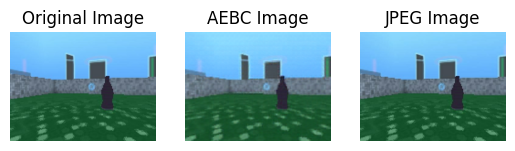

In [30]:
test_dataset_images(model, 1)

Image fruits

Compression time: 0.06632184982299805 s | 66.32184982299805 ms 
Decompression time: 0.0713653564453125 s | 71.3653564453125 ms 
Smoothing time: 0.024336814880371094 s | 24.336814880371094 ms 

Original image size: 446850 bytes | 3574800 bits

Required size to represent it (entropy): 28224.94 bytes | 225799.53 bits
Theoretical Compression factor: x15.831742343353515

Compressed file size: 29448 bytes | 235584 bits
Real Compression factor: x15.174205378973106
R: 0.898681640625 bpp
D: 13.07145367018677 (RMSE)
D: 0.9333438277244568 (Multiscale SSIM)

Compressed jpeg file size: 104879 bytes | 839032 bits
jpeg Compression factor: x4.260624147827497
aebc/jpeg Compression factor: x3.5614982341754957
R: 3.200653076171875 bpp
D: 3.5552876954377024 (RMSE)
D: 0.9906896948814392 (Multiscale SSIM)


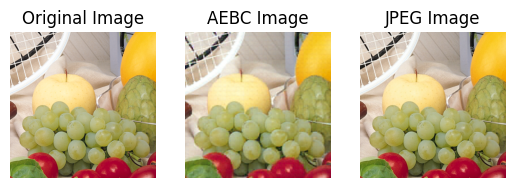



Image lena

Compression time: 0.06818437576293945 s | 68.18437576293945 ms 
Decompression time: 0.08191514015197754 s | 81.91514015197754 ms 
Smoothing time: 0.013152837753295898 s | 13.152837753295898 ms 

Original image size: 512673 bytes | 4101384 bits

Required size to represent it (entropy): 30109.33 bytes | 240874.64 bits
Theoretical Compression factor: x17.02704771809143

Compressed file size: 31377 bytes | 251016 bits
Real Compression factor: x16.339133760397743
R: 0.957550048828125 bpp
D: 10.922660657487398 (RMSE)
D: 0.9364129900932312 (Multiscale SSIM)

Compressed jpeg file size: 107761 bytes | 862088 bits
jpeg Compression factor: x4.7575003943912915
aebc/jpeg Compression factor: x3.4343946202632503
R: 3.288604736328125 bpp
D: 4.405984207686054 (RMSE)
D: 0.9864800572395325 (Multiscale SSIM)


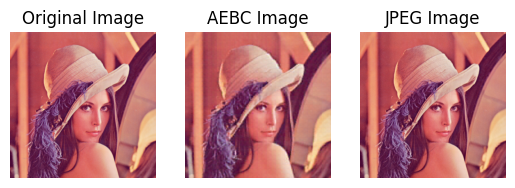



Image mandril

Compression time: 0.07249116897583008 s | 72.49116897583008 ms 
Decompression time: 0.0758965015411377 s | 75.8965015411377 ms 
Smoothing time: 0.01086568832397461 s | 10.86568832397461 ms 

Original image size: 632934 bytes | 5063472 bits

Required size to represent it (entropy): 29676.12 bytes | 237408.94 bits
Theoretical Compression factor: x21.328059732376335

Compressed file size: 30969 bytes | 247752 bits
Real Compression factor: x20.437663469921535
R: 0.945098876953125 bpp
D: 24.665196615523627 (RMSE)
D: 0.837938129901886 (Multiscale SSIM)

Compressed jpeg file size: 195513 bytes | 1564104 bits
jpeg Compression factor: x3.2372987985453654
aebc/jpeg Compression factor: x6.31318415189383
R: 5.966583251953125 bpp
D: 10.017656886896294 (RMSE)
D: 0.9837195873260498 (Multiscale SSIM)


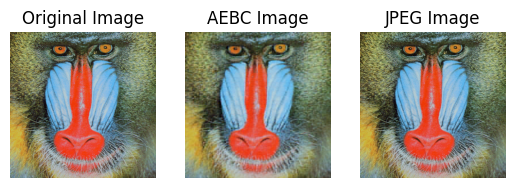



Image pajarillo

Compression time: 0.09520483016967773 s | 95.20483016967773 ms 
Decompression time: 0.08111071586608887 s | 81.11071586608887 ms 
Smoothing time: 0.013400554656982422 s | 13.400554656982422 ms 

Original image size: 237034 bytes | 1896272 bits

Required size to represent it (entropy): 25767.91 bytes | 206143.25 bits
Theoretical Compression factor: x9.198807140180433

Compressed file size: 27077 bytes | 216616 bits
Real Compression factor: x8.754071721387156
R: 0.826324462890625 bpp
D: 12.236782754589708 (RMSE)
D: 0.9467596411705017 (Multiscale SSIM)

Compressed jpeg file size: 66964 bytes | 535712 bits
jpeg Compression factor: x3.5397228361507675
aebc/jpeg Compression factor: x2.4730952468885032
R: 2.0435791015625 bpp
D: 1.8807353146823262 (RMSE)
D: 0.9970794320106506 (Multiscale SSIM)


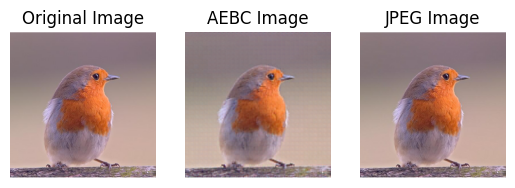



Image peppers

Compression time: 0.06862020492553711 s | 68.62020492553711 ms 
Decompression time: 0.0895545482635498 s | 89.5545482635498 ms 
Smoothing time: 0.011920928955078125 s | 11.920928955078125 ms 

Original image size: 519968 bytes | 4159744 bits

Required size to represent it (entropy): 29880.96 bytes | 239047.66 bits
Theoretical Compression factor: x17.40131681378909

Compressed file size: 31141 bytes | 249128 bits
Real Compression factor: x16.697215889020907
R: 0.950347900390625 bpp
D: 11.541362349885624 (RMSE)
D: 0.9321759343147278 (Multiscale SSIM)

Compressed jpeg file size: 127204 bytes | 1017632 bits
jpeg Compression factor: x4.087670199050344
aebc/jpeg Compression factor: x4.084775697633345
R: 3.8819580078125 bpp
D: 6.288235400290203 (RMSE)
D: 0.9817187786102295 (Multiscale SSIM)


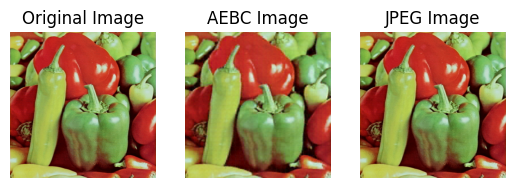

In [31]:
test_exam_images(model)

## Compute and display R-D curve

In [32]:
def plot_rd_curves(models, jpeg_qualities = [3, 50, 99], display_values=False):
    compressors = {}
    decompressors = {}

    distortion_values = {}
    rate_values = {}

    for model_name, lmbda in models.items():
        model_path = f"models/{model_name}.keras"
        model = load_model(model_path)
        compressor, decompressor = make_codec(model)
        compressors[model_name] = compressor
        decompressors[model_name] = decompressor

        distortion_values[lmbda] = []
        rate_values[lmbda] = []

    jpeg_distortion_values = {}
    jpeg_rate_values = {}

    for quality in jpeg_qualities:
        jpeg_distortion_values[quality] = []
        jpeg_rate_values[quality] = []

    filenames = ["fruits.png", "lena.png", "mandril.png", "pajarillo.png", "peppers.png"]

    for filename in filenames:
        filename, ext = filename.split(".")

        image_file = tf.keras.utils.load_img(f"test_images/{filename}.{ext}")
        image_array = tf.keras.utils.img_to_array(image_file)
        image = tf.convert_to_tensor(image_array)
        image = tf.squeeze(image)

        num_pixels = tf.reduce_prod(tf.shape(image)[:-1])

        for model_name, lmbda in models.items():
            compressed_codestream, entropy = compressors[model_name](image)

            save_compressed_image(filename, compressed_codestream)

            compressed_file = load_compressed_image(filename)

            reconstructed_image = decompressors[model_name](compressed_file)

            compressed_size = get_compressed_file_bytes_size(filename)

            rate = (compressed_size*8)/num_pixels
            distortion_msssim = tf.squeeze(tf.image.ssim_multiscale(image.numpy().astype(np.double), reconstructed_image.astype(np.double), 255))

            distortion_values[lmbda].append(distortion_msssim)
            rate_values[lmbda].append(rate)

        for quality in jpeg_qualities:
            jpeg_encoded = tf.image.encode_jpeg(image.numpy().squeeze().astype(np.uint8), quality=quality)

            jpeg_filepath = f"compressed_images/{filename}.jpeg"
            with open(jpeg_filepath, "wb") as file:
                file.write(jpeg_encoded.numpy())

            jpeg_decoded = tf.image.decode_jpeg(jpeg_encoded)

            compressed_size_jpeg = get_file_bytes_size(jpeg_filepath)
            rate_jpeg = (compressed_size_jpeg*8)/num_pixels
            distortion_msssim_jpeg = tf.squeeze(tf.image.ssim_multiscale(image.numpy().astype(np.double), jpeg_decoded.numpy().astype(np.double), 255))

            jpeg_distortion_values[quality].append(distortion_msssim_jpeg)
            jpeg_rate_values[quality].append(rate_jpeg)

    mean_distortions = []
    mean_rates = []

    mean_jpeg_distortions = []
    mean_jpeg_rates = []

    for lmbda in models.values():
        mean_distortions.append(np.mean(distortion_values[lmbda]))
        mean_rates.append(np.mean(rate_values[lmbda]))

    for quality in jpeg_qualities:
        mean_jpeg_distortions.append(np.mean(jpeg_distortion_values[quality]))
        mean_jpeg_rates.append(np.mean(jpeg_rate_values[quality]))

    fig, ax = plt.subplots()
    ax.plot(mean_rates, mean_distortions, label='AEBC')
    ax.plot(mean_jpeg_rates, mean_jpeg_distortions, label='JPEG')
    ax.set_xlabel('Rate (bits/pixel)')
    ax.set_ylabel('Distortion (MS-SSIM)')
    ax.set_title('Rate-Distortion Curve with MSSSIM')
    ax.legend()

    plt.show()

    if display_values:
        print("AEBC results: (rates, distortions)")
        print(mean_rates)
        print(mean_distortions)
        print("JPEG results: (rates, distortions)")
        print(mean_jpeg_rates)
        print(mean_jpeg_distortions)

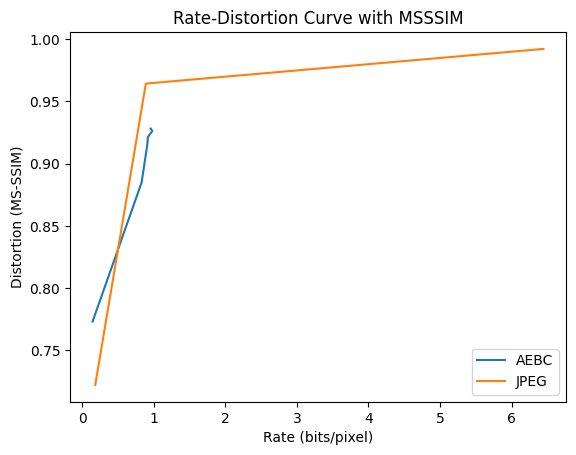

AEBC results: (rates, distortions)
[0.147491455078125, 0.83177490234375, 0.908892822265625, 0.9156005859375, 0.919287109375, 0.981732177734375, 0.95882568359375]
[0.7731308, 0.88469726, 0.9140674, 0.91732615, 0.9212761, 0.9261098, 0.9281168]
JPEG results: (rates, distortions)
[0.18487548828125, 0.89158935546875, 6.443206787109375]
[0.72224355, 0.96420175, 0.99203885]


In [ ]:
#models = {
#    "2024_01_25-15_47_54-lambda5-8x8": 5,
#    "2024_01_24-16_35_45-lambda500-8x8": 500,
#    "2024_01_24-16_43_31-lambda1000-8x8": 1000,
#    "2024_01_24-16_50_52-lambda2000-8x8": 2000,
#}

models = {
    "2024_01_25-18_28_17-lambda5-16x16": 5,
    "2024_01_24-16_11_33-lambda500-16x16": 500,
    "2024_01_24-16_26_58-lambda1000-16x16": 1000,
    "2024_01_24-16_19_52-lambda2000-16x16": 2000,
    "2024_01_25-18_36_12-lambda10000-16x16": 10000,
    "2024_01_25-18_43_12-lambda25000-16x16": 25000,
    "2024_01_26-23_31_54-lambda5000000-16x16": 5000000,
}

jpeg_qualities = [3, 50, 99]

display_result_values = True

plot_rd_curves(models, jpeg_qualities, display_result_values)

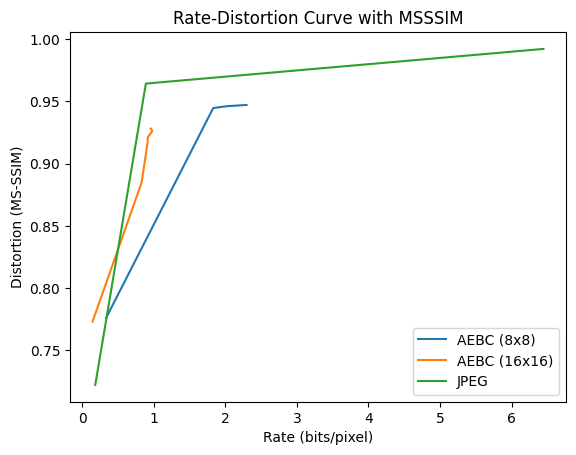

In [ ]:
aebc8x8_rates = [0.33643798828125, 1.83214111328125, 2.032476806640625, 2.29739990234375]
aebc8x8_distortions = [0.77603006, 0.94455194, 0.94608945, 0.9470275]

aebc16x16_rates = [0.147491455078125, 0.83177490234375, 0.908892822265625, 0.9156005859375, 0.919287109375, 0.98172607421875, 0.95882568359375]
aebc16x16_distortions = [0.773131, 0.88469905, 0.9140689, 0.9173279, 0.9212774, 0.92611015, 0.92811835]

jpeg_rates = [0.18487548828125, 0.89158935546875, 6.443206787109375]
jpeg_distortions = [0.72224474, 0.9642029, 0.9920265]

fig, ax = plt.subplots()
ax.plot(aebc8x8_rates, aebc8x8_distortions, label='AEBC (8x8)')
ax.plot(aebc16x16_rates, aebc16x16_distortions, label='AEBC (16x16)')
ax.plot(jpeg_rates, jpeg_distortions, label='JPEG')
ax.set_xlabel('Rate (bits/pixel)')
ax.set_ylabel('Distortion (MS-SSIM)')
ax.set_title('Rate-Distortion Curve with MSSSIM')
ax.legend()

plt.show()